# Customer Attrition Forecasting in Banking


### Problem Statement
Lison Bank is experiencing customer churn in its credit card services, with approximately **16% of customers leaving**. Understanding which customers are likely to churn and which remain loyal is critical for designing **targeted retention strategies** and maximizing revenue. The challenge is compounded by **class imbalance** and limited context on certain customer behaviors.

### Project Objectives
- Build **predictive models** to identify customers at risk of churn.  
- Provide **actionable insights** into key factors driving churn.  
- Recommend **retention strategies** to improve customer loyalty and revenue.

### Project Procedure
1. **Data Exploration and Preprocessing**  
   - Handle missing values and encode categorical features.  
   - Scale numeric features.  
2. **Handling Class Imbalance**  
   - Apply techniques such as **SMOTE** to ensure minority churn cases are represented.  
3. **Modeling**  
   - Use **supervised classification models**, including **Random Forest, Gradient Boosting, and XGBoost**.  
4. **Evaluation**  
   - Assess model performance using **ROC-AUC, Precision, Recall, F1-score**, and **confusion matrices**.  
5. **Insights and Recommendations**  
   - Identify **key drivers of churn**.  
   - Provide **recommendations for customer retention strategies**.

   ---


## 1. Import the libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [35]:
# Remove gridlines
sns.set_style("white") 

## 2. Import the Dataset

In [36]:
# Load the dataset
df_orig = pd.read_csv('BankChurners.csv')
df_orig.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


By observing the first 5 rows, there are 3 things I notice:

1. We have 3 unnecessary columns that won’t be used in our model these are:

- `CLIENTNUM` and the two `Naive_Bayes` model columns.

2. There are columns that will need to be encoded, such as:

- `Attrition_Flag` (Target), `Gender`, `Card_Category` and `Education_Level`

3. The `Income_Category` column displays income in ranges. I’ll need to use some type of encoding here also.

Let’s explore the dataset a bit more and deal with these.

---

## 3. Data Exploration and Cleaning

This is one of the most crucial steps. We’ll take a closer look at our dataset and see what we’re working with:
- Check column names, data types, and summary statistics
- Explore distributions and unique values
- Further identify and remove any unnecessary columns
- Check for duplicates and missing values

Basically, all the fun stuff that gets our data ready for modeling! 
Let’s dive in and start exploring.

In [37]:
# Let's first drop the unnecessary columns that do not provide any useful information for our analysis.

df = df_orig.drop(columns=['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
                      'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

print('Columns dropped successfully.')
print(f'Columns renmaining:{df.columns}')

Columns dropped successfully.
Columns renmaining:Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


In [38]:
# Now let's display the basic information and shape about the dataset
print(df.info())
print(f'\n The dataset contains {df.shape[0]} rows')
print(f'\n The dataset contains {df.shape[1]} columns')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

From the information above, our dataset has 10,127 rows and 20 columns — with 6 categorical (including the target variable) and 14 numerical features.

Overall, it looks like a pretty manageable dataset to work with. Next let's look at the summary statistics

In [39]:
# let's check for missing values and duplicates
print(df.isnull().sum())
print('--'*40)

print('\n The number of duplicates is', df.duplicated().sum())

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
--------------------------------------------------------------------------------

 The number of duplicates is 0


Great! we do not have any missing or duplicate values which makes our work easier.

In [40]:
# let's check the summary statistics of the numerical columns in the dataset

df.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


From my observation, the data will require standardization before modeling if we are to use any linear models. For example, Total_Trans_Amt has a mean of 4404, while Avg_Utilization_Ratio averages 0.27, showing features are on different scales. Some features, like Avg_Open_To_Buy, have high variance, reinforcing the need for scaling.

Let's explore distributions and unique values

---

## 4. Visualisation

#### i. Univariate Analysis

Here, we’ll take a closer look at each feature on its own. 

- For categorical columns, we’ll use bar charts to see how the values are distributed.
- For numerical columns, we’ll use histograms to understand the spread, skew, and any unusual patterns. 

Basically, it’s all about getting to know our data one column at a time before we dig deeper!

In [41]:
# distributions and unique values
cat_cols = df.columns[df.dtypes == object]
cat_cols

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

Before visualizing the categorical features let's first analyse our Target Variable

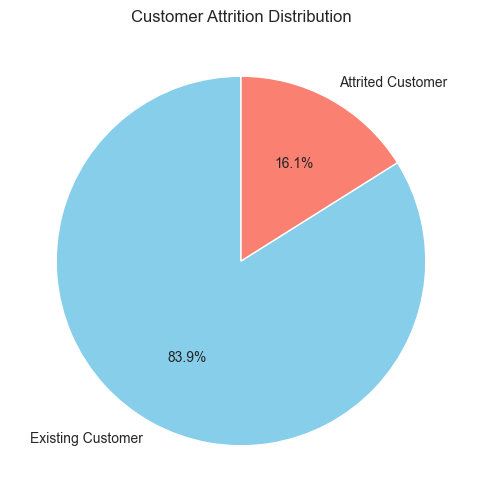

In [42]:

# Count values for Attrition_Flag
counts = df['Attrition_Flag'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue','salmon'])
plt.title("Customer Attrition Distribution")
plt.show()


### **Target Variable**

**Attrition_Flag** (Target variable) – There is a clear imbalance between existing customers (84%) and attrited customers (16%). Without addressing this, the model may lean toward the majority class, reducing prediction reliability. To handle this, I will apply SMOTE, which creates synthetic examples of the minority class, helping the model learn patterns from both classes more effectively.


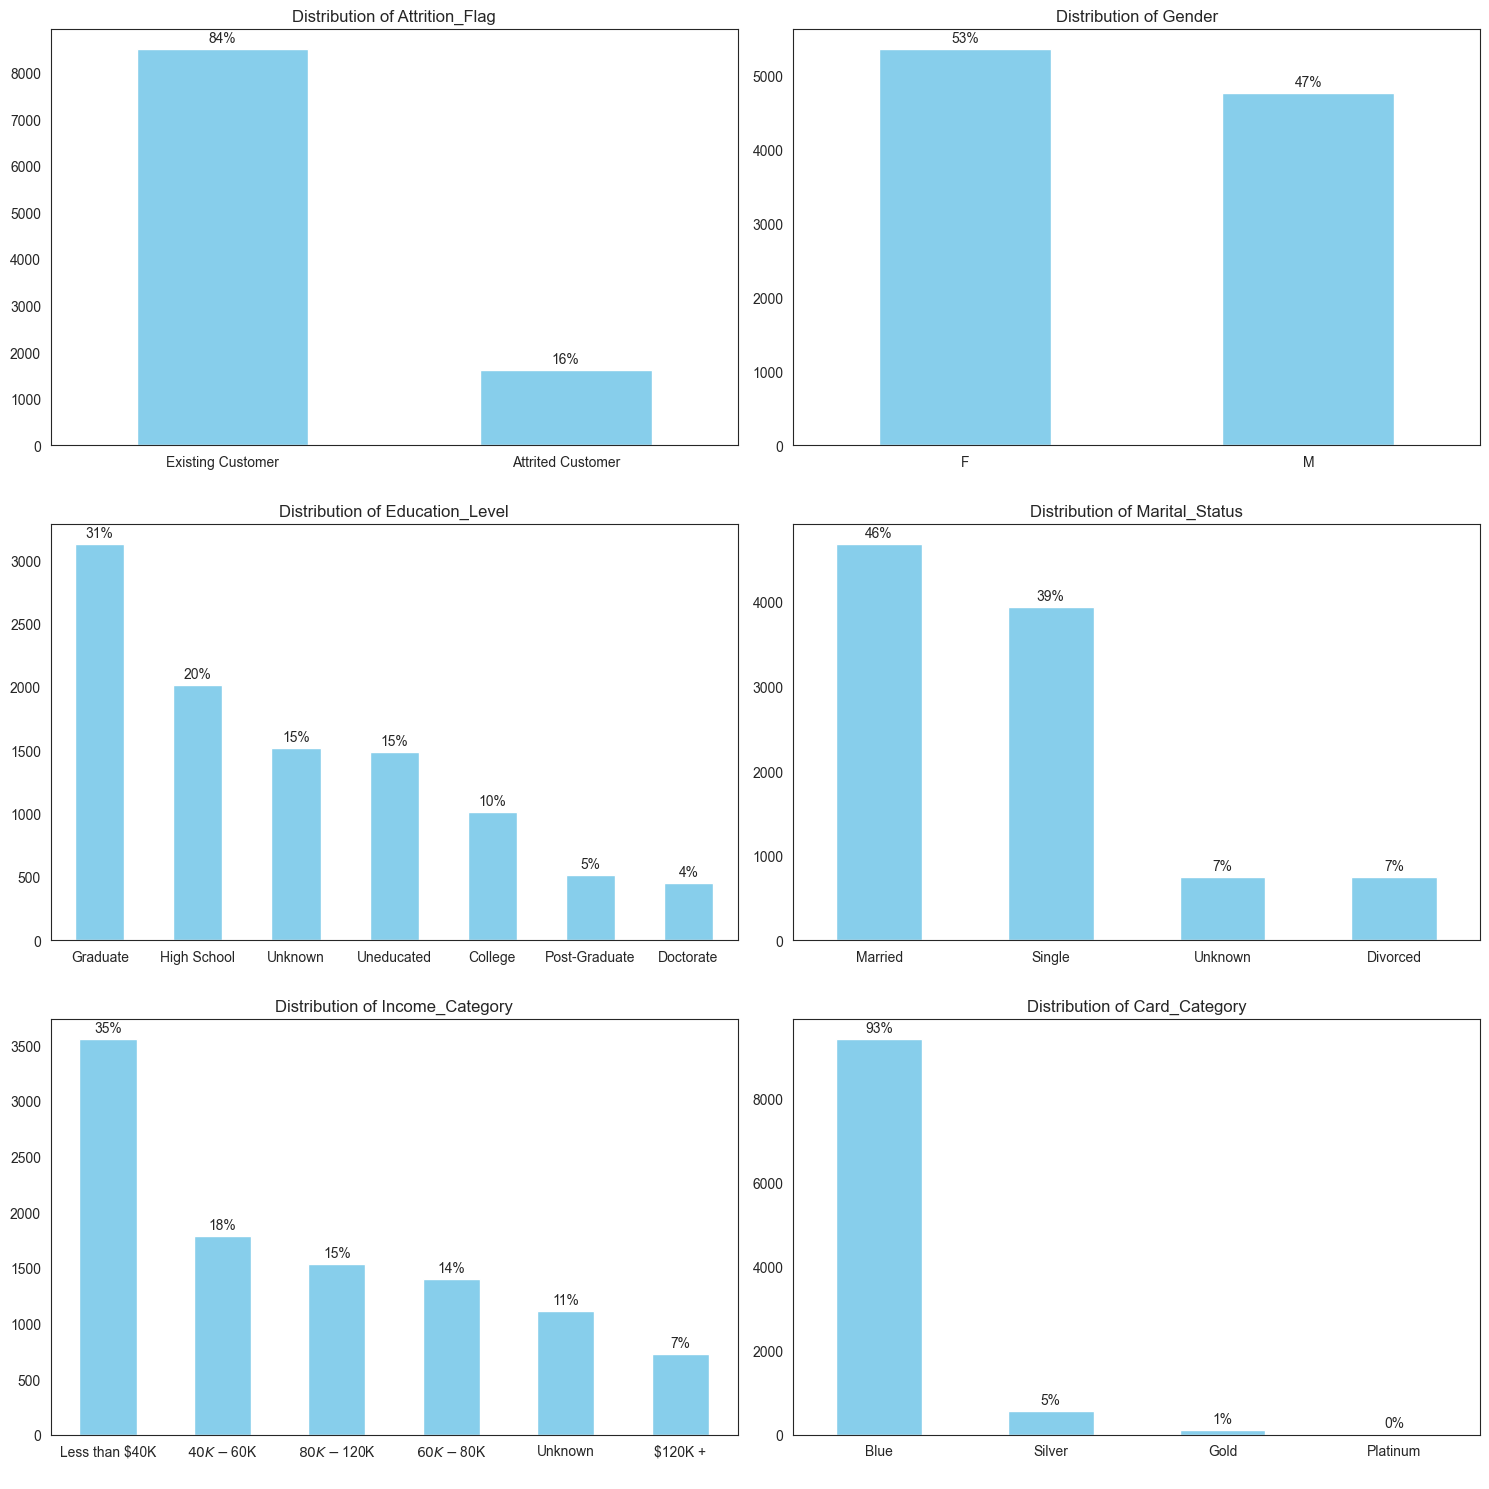

In [43]:
#i will be plotting bar charts for all of them and include percentages for comparison

fig, axes = plt.subplots(3,2, figsize=(15,15))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    counts = df[col].value_counts()
    percentage = counts/counts.sum()*100

    counts.plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(' ')
    axes[i].tick_params(axis='x', rotation=0)

    # add perentages
    for j, val in enumerate(counts):
        axes[i].text(j, val + counts.max()*0.01, f'{percentage.iloc[j]:.0f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Observation

#### **Categorical Features**

1. **Gender** – Distribution is fairly balanced, with slightly more females than males. While gender alone may not strongly predict churn, it could interact with other features like age or income to reveal patterns. The balance means the model is unlikely to be biased toward one gender.

2. **Education Level** – Assuming most customers with unknown education lack formal education, about 70% of customers have a formal education level, and around 35% have higher education (college, postgraduate, or doctorate). This suggests the model may detect patterns where higher-educated customers behave differently, potentially influencing churn predictions.

3. **Marital Status** – Most customers are married or single, making up about 85% of the dataset. Married customers may have more stable financial behavior, while single customers may engage differently with bank products. 

4. **Income Category** – Around 70% of customers fall into the lower to middle-income range, with fewer high-income and 11% unknown. Income skew may influence churn patterns.

5. **Card Category** – The vast majority hold a Blue card, with very few holding Silver, Gold, or Platinum. While the imbalance may limit predictive power for card type alone, combining it with features like transaction history or credit limit could help the model identify high-risk or upgrade-prone customers.

---


**Numeric Features**

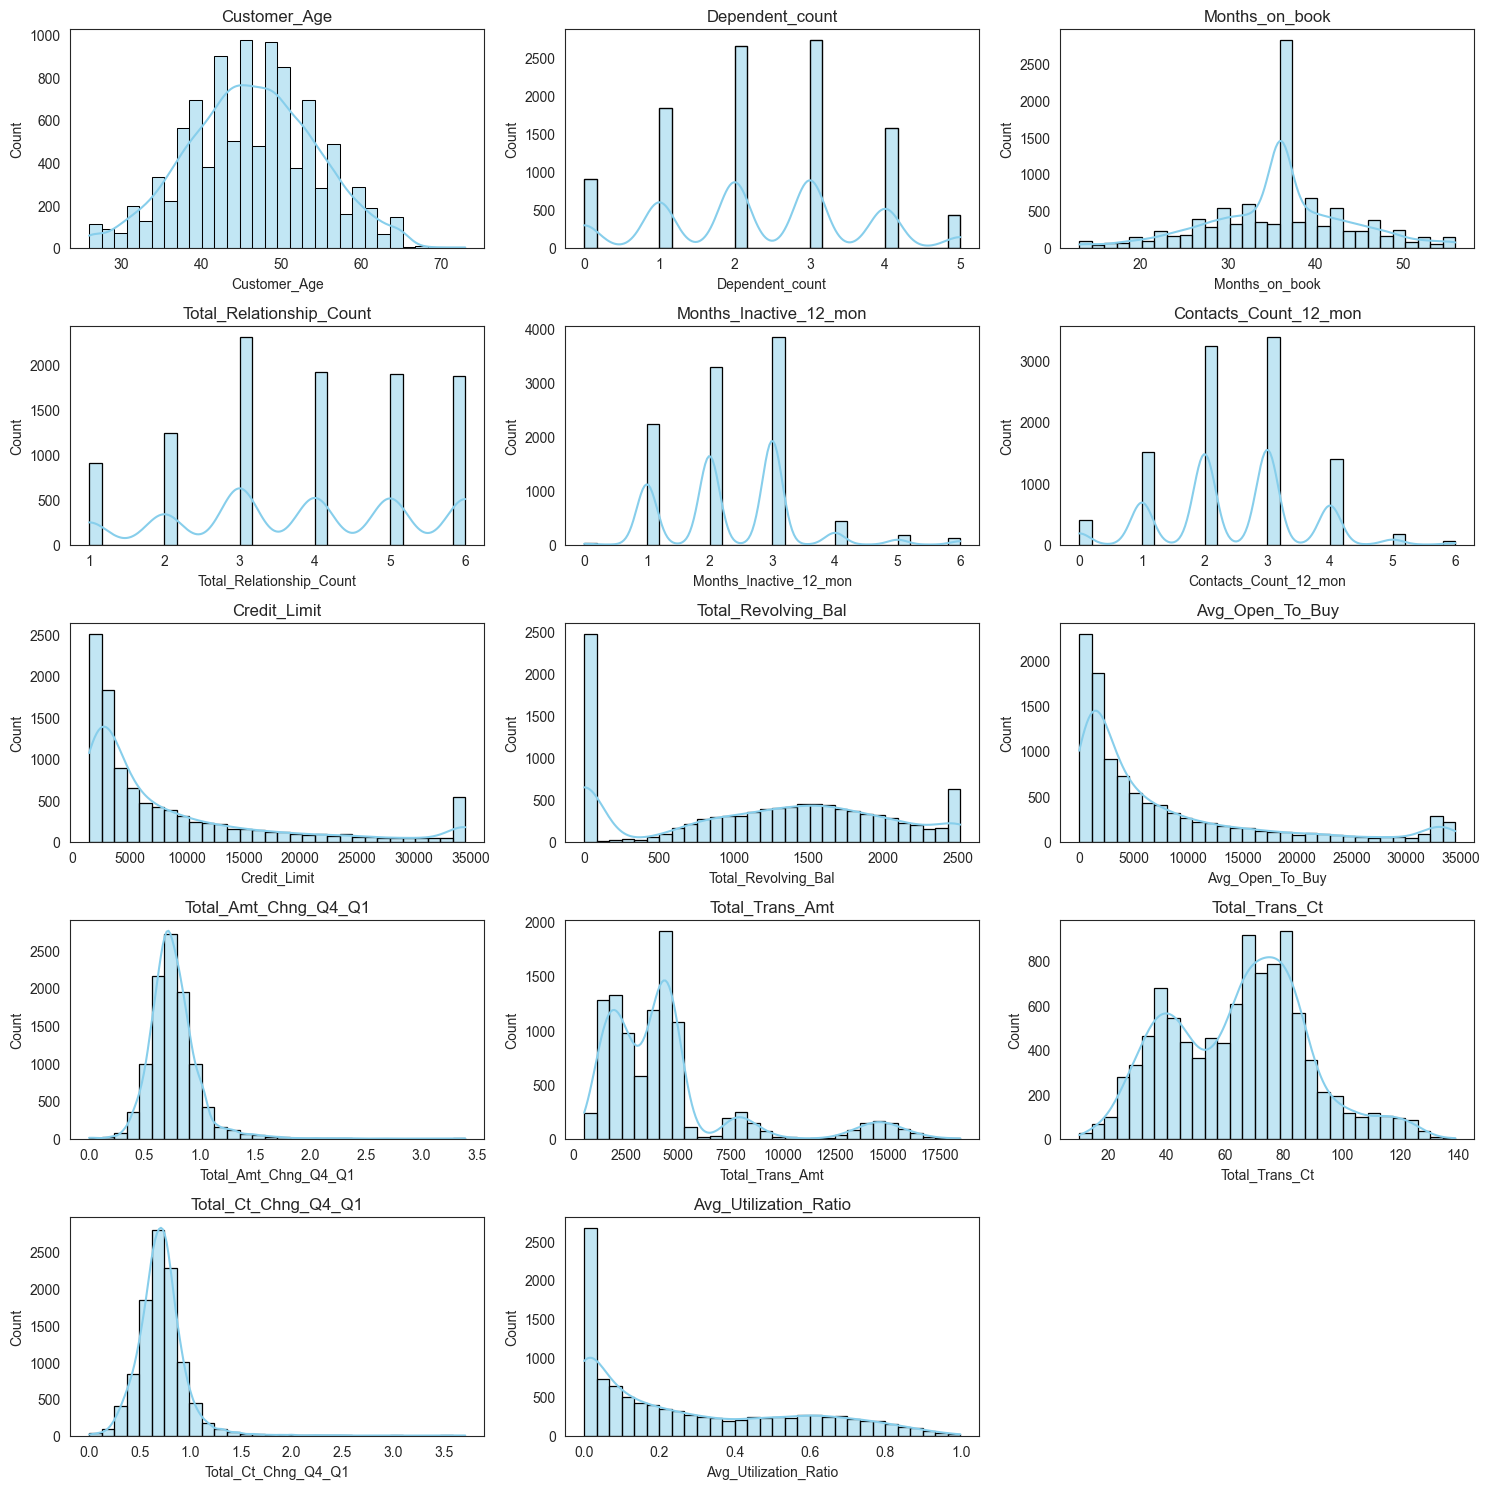

In [44]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 15))

for i, col in enumerate(num_cols):
    plt.subplot(5, 3, i + 1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.show()

**1. Age & Transaction Count**  
- These are nicely balanced, almost normal features.  
- No transformation needed and they work well with most models.

**2. Credit Limit, Utilization & Transaction Amount**  
- These are heavily right-skewed, with a small group far above the rest.  
- A log transform helps stabilize them for models like Logistic Regression.

**3. Dependents, Contacts & Months Inactive**  
- These are discrete features with clear peaks.They form natural customer segments.  
- I would treat them as categorical/ordinal to capture those behavioral groups.

**4. Months_on_book (Tenure)**  
- Most customers fall in the mid-tenure range (around 36–40 months).  
- This pattern suggests early churn or slower customer acquisition.

**5. Quarterly Change Metrics**  
- Most customers stay steady, but the sharp drops in activity stand out.  
- These outliers often signal financial stress or upcoming churn.

**6. Hidden Segments**
- Multi-modal patterns (e.g., Dependent Count, Transaction Amount) reveal distinct customer groups.
- Useful for feature engineering or clustering.

---

#### ii. Bivariate Analysis

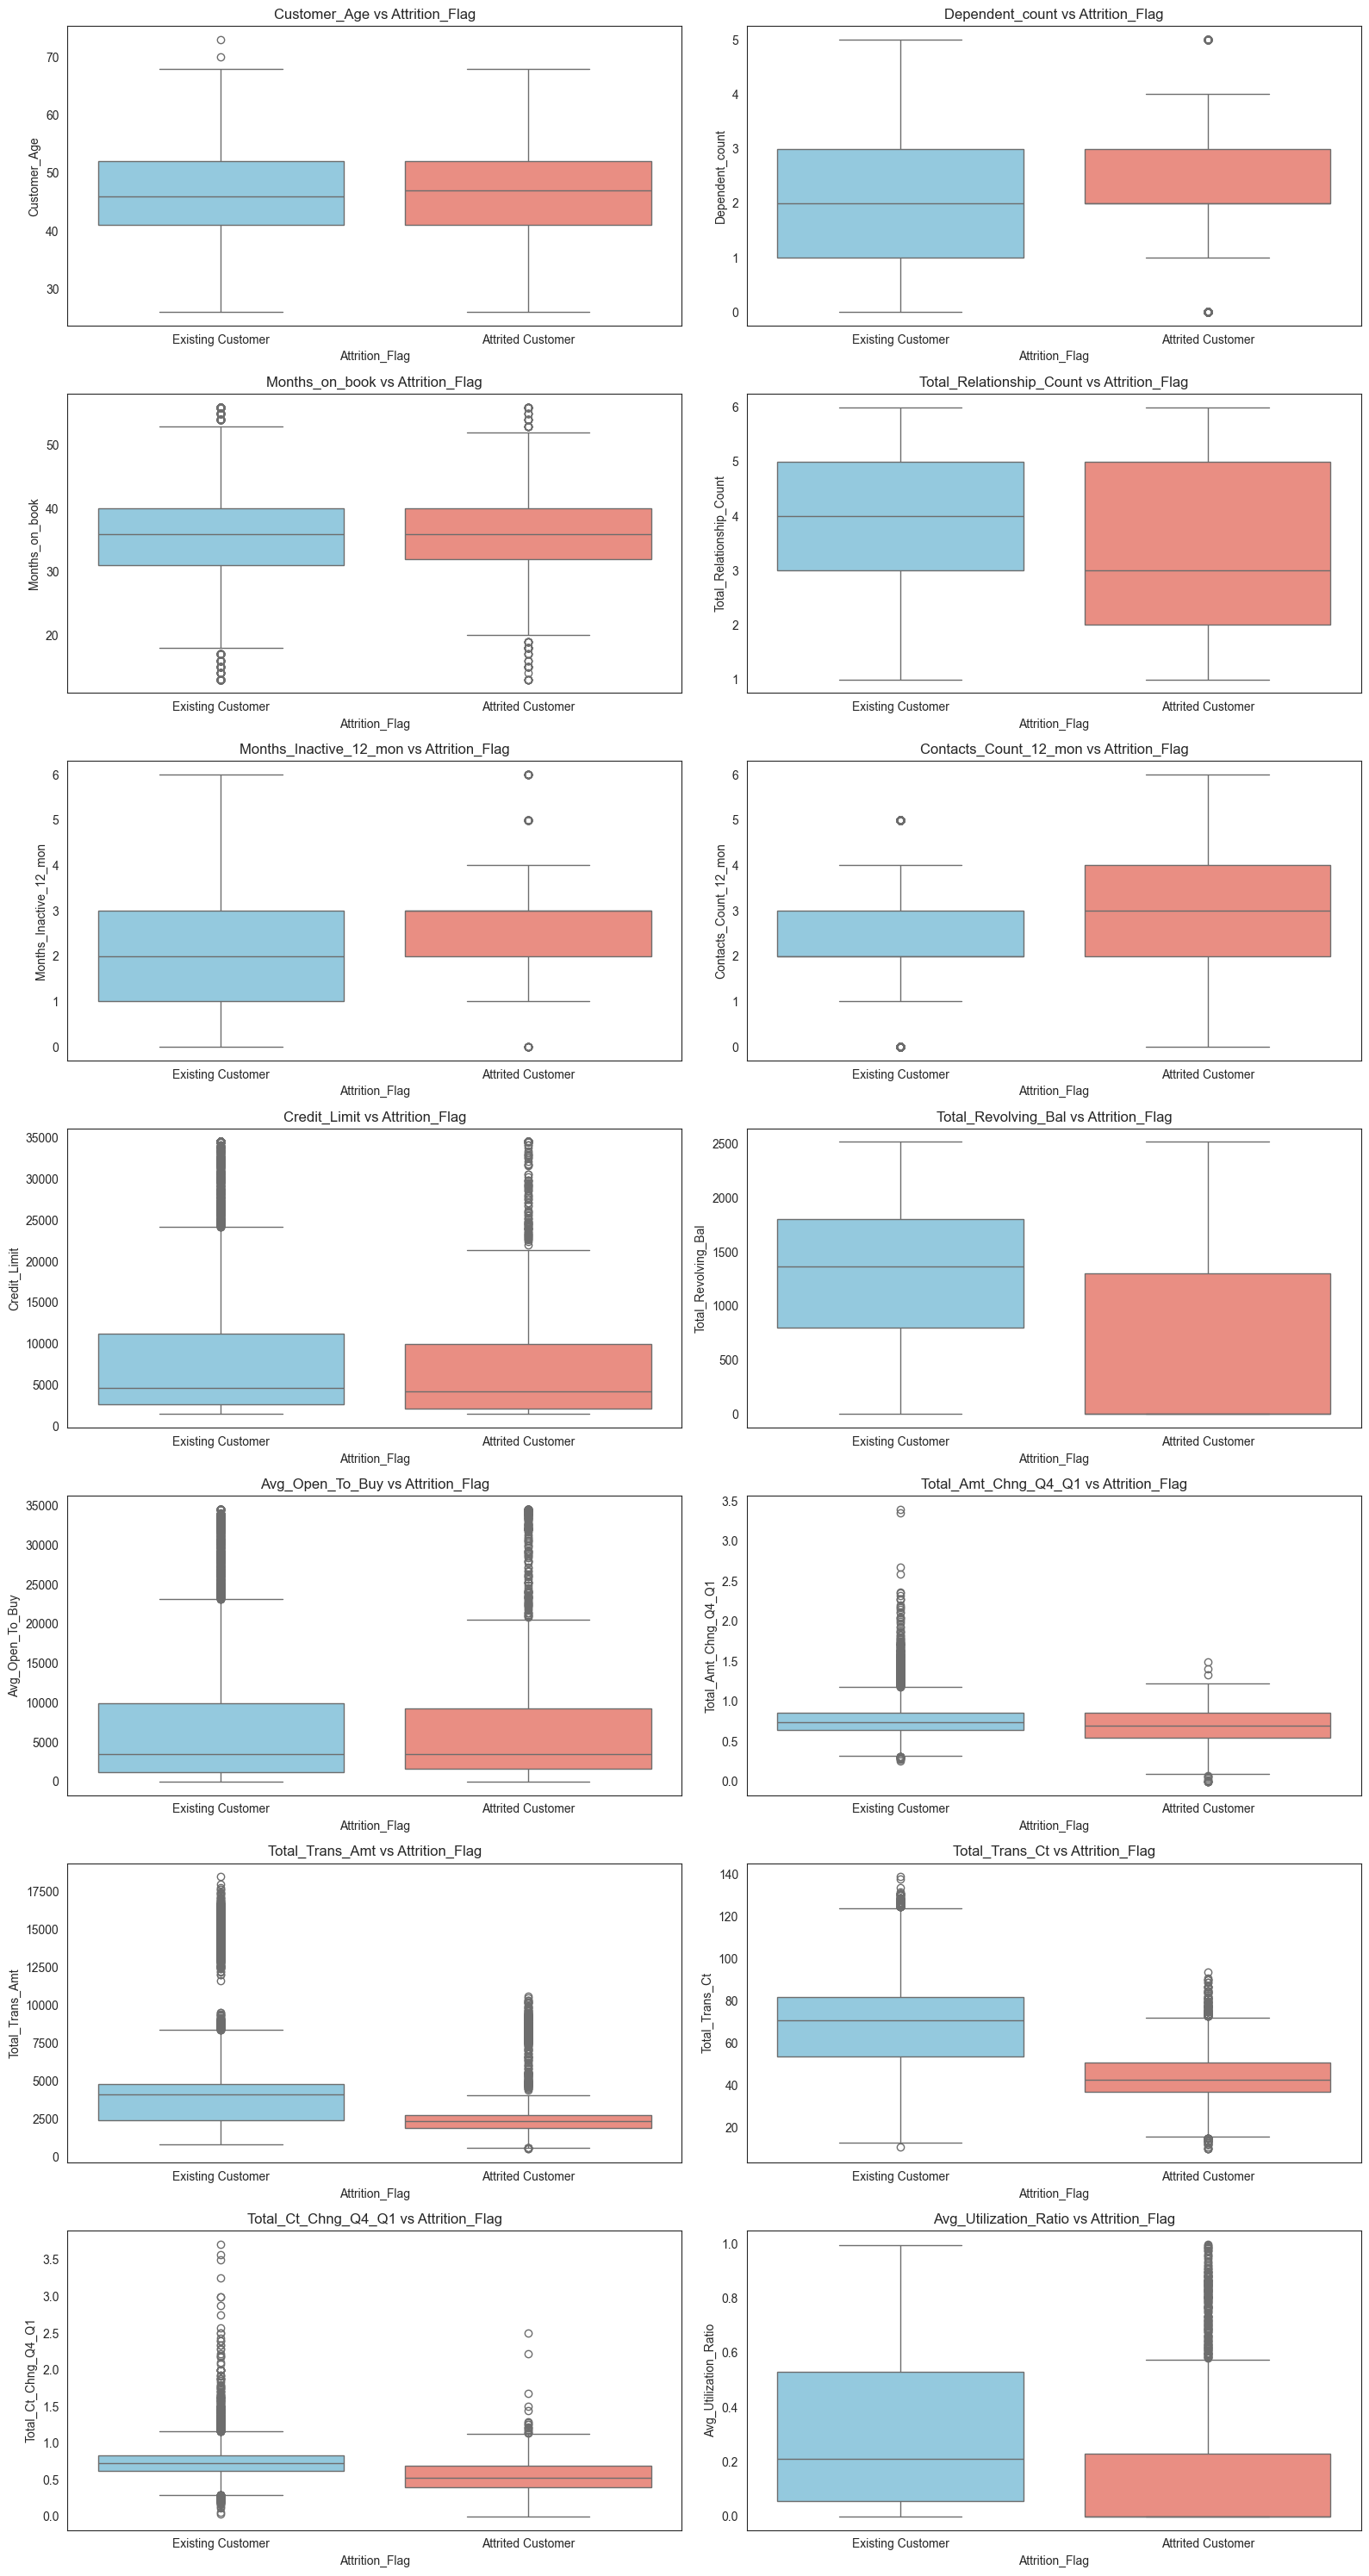

In [45]:
plt.figure(figsize=(16, 30))

# Define a palette for the two classes
palette = {'Existing Customer': 'skyblue', 'Attrited Customer': 'salmon'} 

for i, col in enumerate(num_cols, 1):
    plt.subplot(7, 2, i)
    sns.boxplot(data=df, x='Attrition_Flag', y=col, palette=palette)
    plt.title(f'{col} vs Attrition_Flag')
plt.tight_layout()
plt.show()

### What the Box Plots Reveal About Customer Churn

The grouped box plots help us compare how each feature differs between Existing Customers and Churned Customers. Shifts in medians, wider spreads, or noticeably different distributions indicate churn-related patterns.

**Tenure and Relationship Depth**

- **Months_on_book**: Churned customers have shorter tenure.
- **Total_Relationship_Count**: Churned customers hold fewer products.
**Insight**: Newer customers and those with fewer products are more likely to churn. This indicates that early engagement and cross-selling are important.

 **Inactivity and Customer Contact**
 
- **Months_Inactive_12_mon**: Churned customers show higher inactivity.
- **Contacts_Count_12_mon**: And they also contact the bank more often.
**Insight**: Low usage combined with frequent support contact may indicate dissatisfaction.

**Credit Behavior Patterns**

- **Avg_Utilization_Ratio**: Churned customers use a higher proportion of their credit limit.
- **Total_Revolving_Bal**: There are higher balances among churned customers.
- **Credit_Limit**: We can see lower credit limits for churned customers.
**Insight**: This indicates that high utilization and financial pressure often precede churn.

**Transaction Activity**
- **Total_Trans_Ct**: There are fewer transactions among churned customers.
- **Total_Trans_Amt**: And lower spending overall.
- **Total_Amt_Chng_Q4_Q1**: Churned customers show sharper declines in spending.
**Insight**: Declining activity is a strong early warning signal.

**Demographics**
- **Customer_Age**, **Dependent_count**: Distributions are similar across both groups.
**Insight**: Demographic variables alone do not strongly drive churn.

**conclusion**
Churn follows observable patterns. Strong indicators include short tenure, fewer products, higher inactivity, high credit utilization, and reduced transaction activity. Monitoring these features helps identify customers at risk earlier.

---

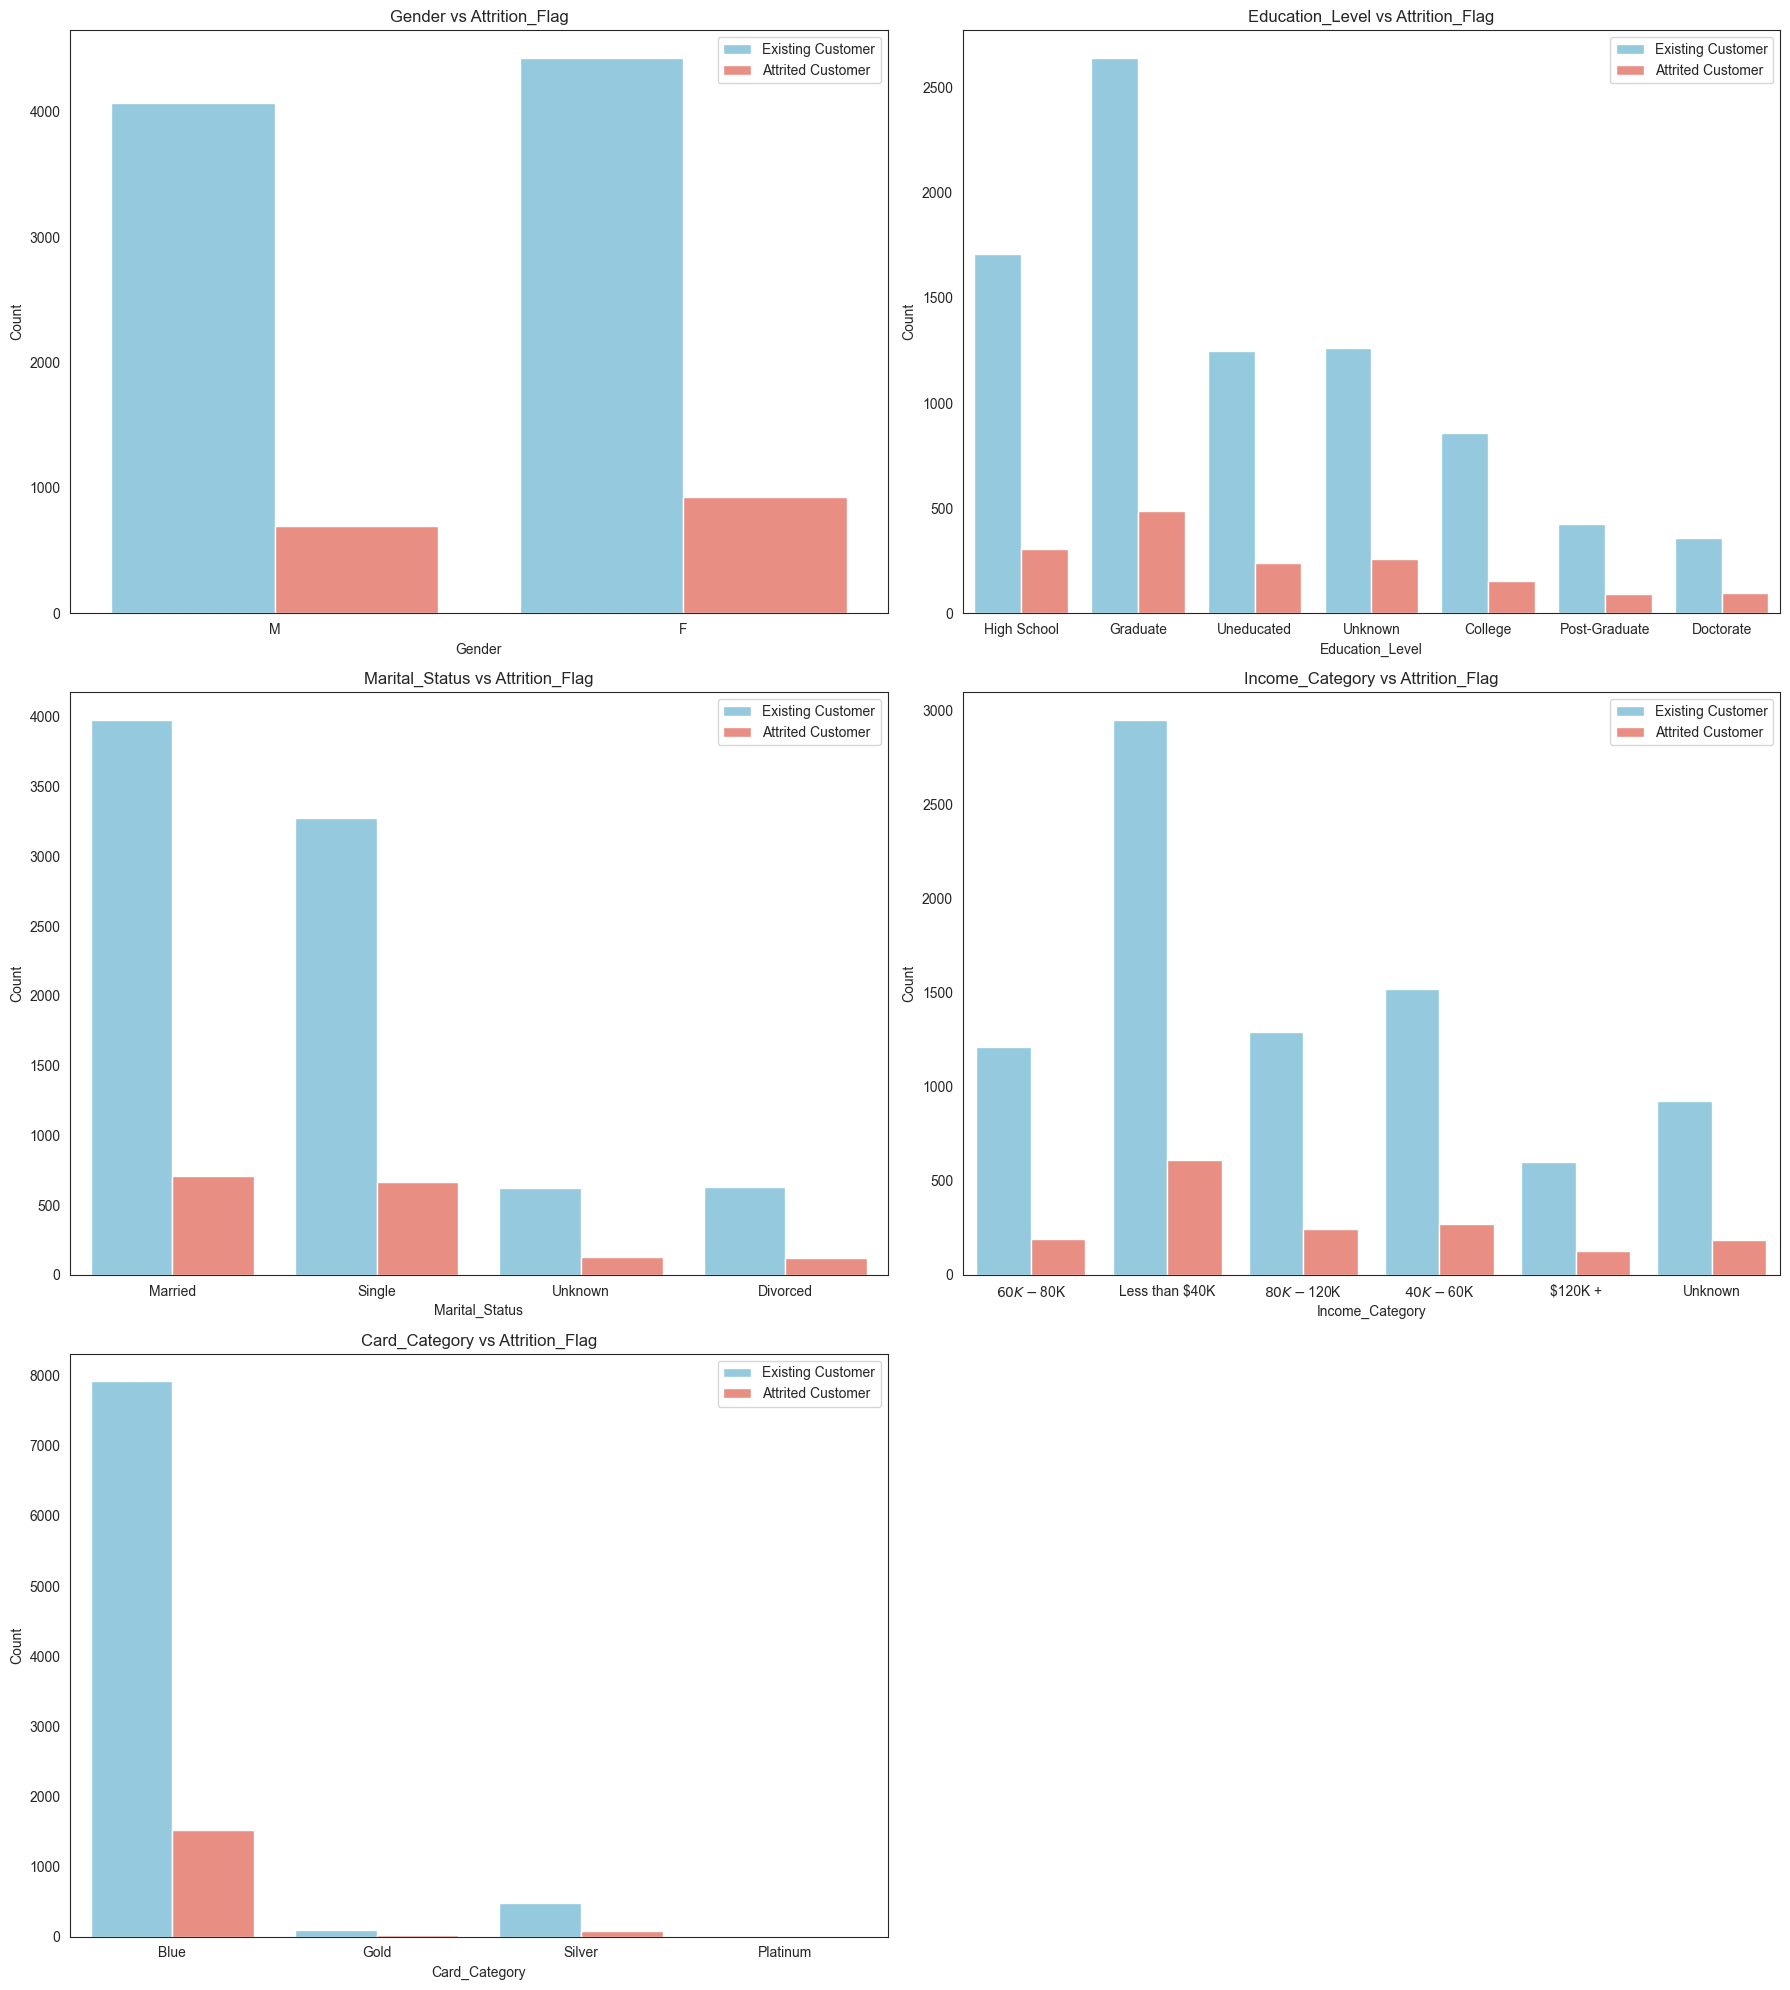

In [46]:
cat_cols = ['Gender', 'Education_Level', 'Marital_Status','Income_Category', 'Card_Category']

plt.figure(figsize=(18, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=col, hue='Attrition_Flag',  palette=['skyblue','salmon'])
    plt.title(f'{col} vs Attrition_Flag')
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.legend(['Existing Customer', 'Attrited Customer'], loc='upper right')
plt.tight_layout()
plt.show()

**Insights Summary**

 **1. Gender**
- More women are customers overall.
- Women churn slightly more than men.

**2. Education Level**
- Graduates form the largest customer and churn group.
- Uneducated customers have the highest **percentage** churn relative to their size.

 **3. Marital Status**
- Married customers churn less.
- Single customers churn the most compared to their group size.

**4. Income Category**
- Customers earning **< \$40K** churn the most.
- High-income customers (\$120K+) rarely churn.

**5. Card Category**
- **Blue card** customers make up most churn cases.
- Premium card holders (Gold/Silver/Platinum) rarely churn.

---


#### iii. **Correlations**

Correlations show how features move together. Strong positive correlations indicate that as one feature increases, the other tends to increase as well, while strong negative correlations indicate that as one increases, the other decreases. Features with very weak or no correlation provide little predictive value on their own. Understanding these relationships helps identify redundant features, highlight key predictors, and guide feature engineering for modeling.

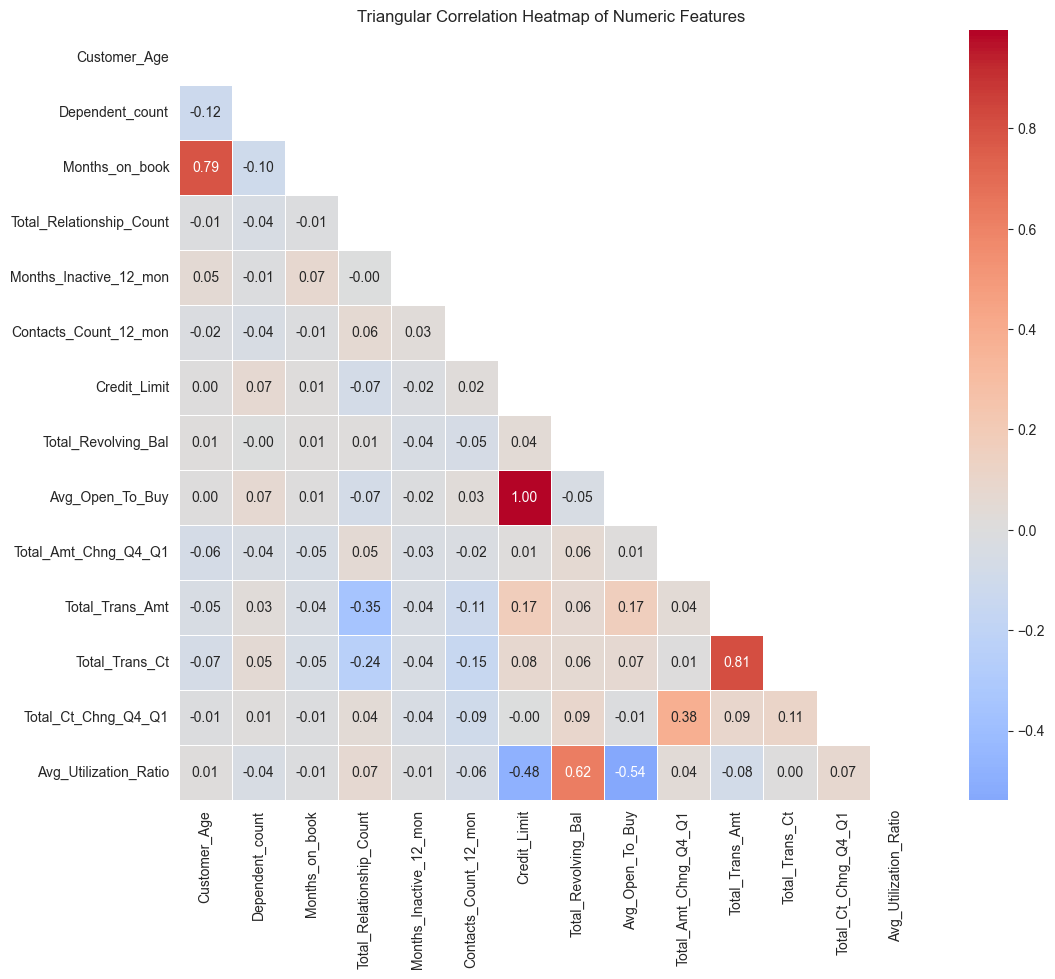

In [47]:
# Select numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot triangular heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Triangular Correlation Heatmap of Numeric Features")
plt.show()


**1. Strong Positive Relationships**  
- **Total_Trans_Ct** and **Total_Trans_Amt** have a strong correlation (0.81). Customers who make more transactions tend to spend more.  
- **Avg_Utilization_Ratio** and **Total_Revolving_Bal** show a solid positive correlation (0.62). Higher utilization is linked to higher revolving balances.  
- **Credit_Limit** and **Avg_Open_To_Buy** are perfectly correlated (1.00). Since they represent the same information, one should be removed to prevent redundancy.

**2. Strong Negative Relationships**  
- **Total_Trans_Ct** and **Months_Inactive_12_mon** have a negative correlation (-0.24). More inactive months lead to fewer transactions.  
- **Avg_Utilization_Ratio** and **Avg_Open_To_Buy** show a negative relationship (-0.54). Higher utilization corresponds to lower available credit, often signaling financial stress.  
- **Total_Revolving_Bal** and **Total_Relationship_Count** are negatively correlated (-0.26). Customers with more products tend to maintain lower revolving balances.

**3. Weak or No Relationships**  
- **Customer_Age**, **Gender**, and **Attrition_Flag** show near-zero correlation with most numeric features, meaning they are not strong predictors on their own.  
- **Dependent_count** and **Months_on_book** also exhibit very weak correlations, suggesting that additional feature engineering may be needed to extract value from them.


---


## 5. Data Preprocessing

Now that we know what our data looks like, it’s time to clean it up and get it ready for modeling. In this step, we’ll:

- Encode the target variable and categorical variables so our models can understand them
- Scale numeric features to make sure no column dominates
- Deal with imbalanced classes to give our model a fair shot
- Select or create features that will help our model predict churn better
- Split the data into training and testing sets

Basically, all the behind-the-scenes work that makes our model smarter and more accurate! Let’s get preprocessing. 


In [48]:
# drop Avg_Open_To_Buy

df = df.drop('Avg_Open_To_Buy', axis =1)

#### i. Encoding

Categorical features can be broadly classified into two types: nominal and ordinal.

**Nominal variables** are categories with no natural order or ranking. For instance, gender, classified as male or female, is a nominal variable.

**Ordinal variables** have categories with a meaningful order or ranking. For example, a feature with levels such as low, medium, and high is ordinal.

In this dataset, the ordinal variables are:

Income_Category

Card_Category

Education_Level

In this notebook, I will first encode the nominal variables then the ordinal variables separately after splitting .

In [49]:
# nominal categories

# Direct mapping for Gender and Attrition_Flag
df['Gender'] = df['Gender'].replace({'M': 0, 'F': 1})
df['Attrition_Flag'] = df['Attrition_Flag'].replace({'Existing Customer': 0, 'Attrited Customer': 1})


In [50]:
# 1. Split the data
y = df['Attrition_Flag']
X = df.drop('Attrition_Flag', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Encode ordinal categorical columns in train and test sets
Income_Category_map = {
    'Less than $40K' : 0,
    '$40K - $60K'    : 1,
    '$60K - $80K'    : 2,
    '$80K - $120K'   : 3,
    '$120K +'        : 4,
    'Unknown'        : 5
}

Card_Category_map = {
    'Blue'     : 0,
    'Silver'   : 1,
    'Gold'     : 2,
    'Platinum' : 3
}

Education_Level_map = {
    'Uneducated'    : 0,
    'High School'   : 1,
    'College'       : 2,
    'Graduate'      : 3,
    'Post-Graduate' : 4,
    'Doctorate'     : 5,
    'Unknown'       : 6
}

X_train = X_train.replace({
    'Income_Category': Income_Category_map,
    'Card_Category': Card_Category_map,
    'Education_Level': Education_Level_map
})

X_test = X_test.replace({
    'Income_Category': Income_Category_map,
    'Card_Category': Card_Category_map,
    'Education_Level': Education_Level_map
})

# 3. One-hot encode Marital_Status
X_train = pd.get_dummies(X_train, columns=['Marital_Status'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Marital_Status'], drop_first=True)

# Make sure train and test have the same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


ii. **Feature Scaling**

- Numeric features were scaled using StandardScaler (mean = 0, std = 1).  
- Scaling is recommended for SMOTE because it generates synthetic samples based on feature distances, and consistent scaling ensures meaningful interpolation.  
- For tree-based models, scaling does not affect performance, but we keep it for consistency and proper handling of new data.  

In [51]:

# Numeric columns
numeric_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
               'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
               'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
               'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# Scale BEFORE SMOTE for logistic regression
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

iii. **handling Imbalanced data with SMOTE  (Synthetic Minority Oversampling Technique)** 

- We apply SMOTE on the training data to oversample the minority class (Attrited Customers). This helps the model learn better from imbalanced data and improves its ability to correctly predict the minority class.
- Without SMOTE, the model may be biased towards the majority class (Existing Customers), leading to poor performance in detecting the minority class (Attrited Customers).




In [52]:
# SMOTE on training only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

### 6. Feature Selection with RFECV

We use **RFECV (Recursive Feature Elimination with Cross-Validation)** to find the most important features for our models.  
- It removes the least important features step by step and checks model performance using cross-validation.  
- This helps improve the model, avoid overfitting, and make the feature set simpler.  
- Works for both Logistic Regression and tree-based models (Random Forest, Gradient Boosting, XGBoost).  

I use Stratified K-Fold 

- It splits the data into 5 parts (folds).
- Ensures that each fold has roughly the same proportion of classes (important for imbalanced data).
- Also to check model performance more reliably.

 Optimal features: 17
Selected features: ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Income_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Single']


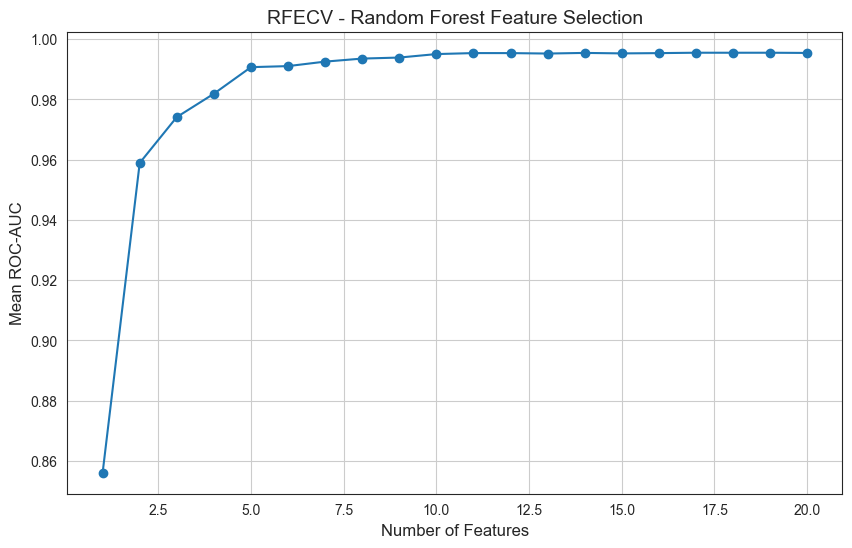

In [53]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
cv = StratifiedKFold(n_splits=5)

# RFECV for feature selection

rfecv = RFECV(estimator=rf, step=1, cv=cv, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train_res, y_train_res)

# Results
print(f" Optimal features: {rfecv.n_features_}")
selected = X_train_res.columns[rfecv.support_].tolist()
print(f"Selected features: {selected}")


# Let's Plot CV scores
plt.figure(figsize=(10,6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'])+1),
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel("Mean ROC-AUC", fontsize=12)
plt.title("RFECV - Random Forest Feature Selection", fontsize=14)
plt.grid(True)
plt.show()

In [54]:
# optimal FeaturesOptimal number of features: 17
features = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 
            'Income_Category', 'Months_on_book', 'Total_Relationship_Count', 
            'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 
            'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 
            'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 
            'Avg_Utilization_Ratio', 'Marital_Status_Single']

# Keep only the selected features
X_train_selected = X_train_res[features]
X_test_selected = X_test_scaled[features]

The rfecv graph shows how well our model performs as we **remove features one by one**  using Random Forest and cross-validated AUC (area under the curve) as the score.


#### What “Optimal Features = 17” Means:
- The model’s performance **peaks at 17 features** adding more doesn’t help, removing more hurts.
- Even with just 2–3 features, the model is already decent (about 0.96 AUC), but it gets better and stabilizes at 17.


 ## 6. Model Selection and Evaluation

We are training and evaluating multiple models to predict customer attrition:

1. **Logistic Regression**: A simple baseline model suitable for binary classification. It helps us understand the linear relationships between features and the target.  
2. **Random Forest**: An ensemble tree-based model that reduces overfitting and captures non-linear relationships in the data.  
3. **Gradient Boosting**: Another tree-based ensemble method that builds trees sequentially, focusing on correcting errors of previous trees. Often performs better on imbalanced or complex datasets.  
4. **XGBoost**: A powerful, optimized gradient boosting implementation known for high performance and efficiency.  

Each model is evaluated using **classification metrics** (precision, recall, F1-score) and **ROC-AUC** to measure how well the model distinguishes between existing and attrited customers. Using multiple models allows us to compare performance and choose the best one for deployment.

**Why we will not use Accuracy to evaluate our models**
- Accuracy measures the overall proportion of correct predictions. However, since our dataset is **imbalanced**,there are many more existing customers than attrited ones.  
- Therefore, a model can have high accuracy just by predicting the majority class, but it will fail to identify the minority class (attrited customers), which is what we really care about.  


### i. Model Training

In [55]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_selected, y_train_res)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_selected, y_train_res)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb.fit(X_train_selected, y_train_res)

# XGBoost
xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb.fit(X_train_selected, y_train_res)

# Evaluate models
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'XGBoost': xgb
}

for name, model in models.items():
    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:,1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1701
           1       0.54      0.80      0.65       325

    accuracy                           0.86      2026
   macro avg       0.75      0.83      0.78      2026
weighted avg       0.89      0.86      0.87      2026

ROC-AUC: 0.9145

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1701
           1       0.81      0.85      0.83       325

    accuracy                           0.94      2026
   macro avg       0.89      0.91      0.90      2026
weighted avg       0.95      0.94      0.94      2026

ROC-AUC: 0.9832

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.91      0.88      0.89       325

    accuracy                           0.97      2026
   macro avg     

### Model Performance Before Hyperparameter Tuning
From the results:  

- **Logistic Regression** has decent performance (ROC-AUC 0.9145) but lower recall for the minority class (1), meaning it misses more churners.  
- **Random Forest** improves performance significantly (ROC-AUC 0.9832) with better balance between precision and recall.  
- **Gradient Boosting** performs even better (ROC-AUC 0.9916) with high precision and recall for both classes.  
- **XGBoost** has the best ROC-AUC (0.9918) and very strong precision/recall for both classes.  

**Conclusion:**  
Before hyperparameter tuning, **XGBoost and Gradient Boosting are the strongest models**, with Random Forest also performing well. Logistic Regression is weaker but can serve as a simple baseline.


### ii. Let's check for signs of overfitting in our models using **roc_curve**

- We use ROC curves to compare model performance on training vs test data and check for overfitting.  
- Large gaps between the curves may indicate overfitting.
-Area Under the ROC Curve for the test data ranges from 0.5 (random guessing) to 1.0 (perfect prediction).


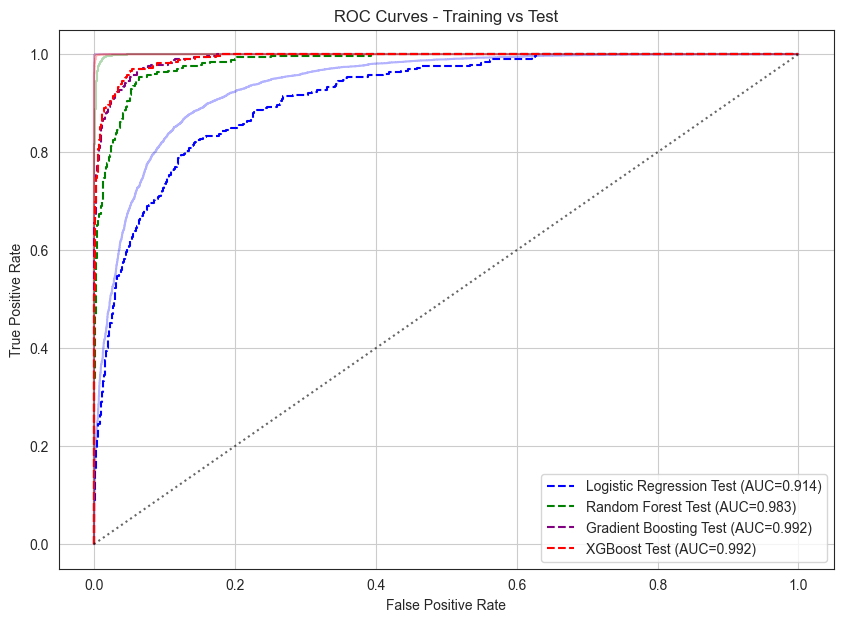

In [56]:
from sklearn.metrics import auc

# Add Gradient Boosting color
colors = {
    'Logistic Regression': 'blue',
    'Random Forest': 'green',
    'Gradient Boosting': 'purple',
    'XGBoost': 'red'
}

plt.figure(figsize=(10, 7))

for name, model in models.items():

    # Train & test predicted probabilities
    y_train_p = model.predict_proba(X_train_selected)[:, 1]
    y_test_p  = model.predict_proba(X_test_selected)[:, 1]

    # ROC curves
    fpr_tr, tpr_tr, _ = roc_curve(y_train_res, y_train_p)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_p)

    # AUC
    auc_te = auc(fpr_te, tpr_te)

    # Train
    plt.plot(fpr_tr, tpr_tr, color=colors[name], alpha=0.3)

    # Test
    plt.plot(fpr_te, tpr_te, '--', color=colors[name],
             label=f"{name} Test (AUC={auc_te:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k:', alpha=0.6)

plt.title("ROC Curves - Training vs Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Looking at the ROC curves, all four models are performing very well  especially on new, unseen test data. That tells us they’re learning real patterns from the data, not just memorizing noise.

**Let’s talk about overfitting for a second:**
Overfitting happens when a model learns the training data too well even the random noise or rare quirks in that specific dataset. As a result, it performs great on training data but poorly on new data (like the test set). You can spot it when the training performance is much better than test performance.

**Now, looking at the chart:**

- **Logistic Regression (blue):** The training (solid) and test (dashed) lines are almost identical. Test AUC = 0.914. Even though this is a simple model, it generalizes really well, no overfitting here.

- **Random Forest (green):** Training and test curves match closely. Test AUC = 0.982. It’s a more complex model, but still doesn’t overfit — meaning it’s not getting tricked by random noise in the training data.

- **XGBoost (red):** The two curves lie right on top of each other. Test AUC = 0.992. This model is powerful and accurate, yet still avoids overfitting which is impressive given how flexible boosting models can be.

- **Gradient Boosting (orange):** Also shows nearly perfect alignment between training and test results. Test AUC = 0.989. Just like XGBoost, it’s complex but still generalizes extremely well.

**Conclusion**: All four models are working really well. None of them are overfitting, they all do just as well on new data as they did on the training data. That’s a big win! XGBoost and Gradient Boosting are the top performers, but even the simpler Logistic Regression is doing great.

### iii. Checking Model Performance with Confusion Matrices
We use **confusion matrices** to see how well each model predicts both classes.  
- Shows the number of **true positives, true negatives, false positives, and false negatives**.  
- Helps identify if a model is misclassifying one class more than the other, especially the minority class.


=== Logistic Regression (Threshold = 0.5) ===
Confusion Matrix:
[[1482  219]
 [  66  259]]
TN = 1482 → Correctly predicted NON-churn (Existing Customers)
FP = 219 → Predicted churn but customer stayed (False Alarm)
FN = 66 → Missed churners (These are critical!)
TP = 259 → Correctly predicted churners
Precision = 0.54
Recall    = 0.80
F1-Score  = 0.65
ROC-AUC   = 0.914



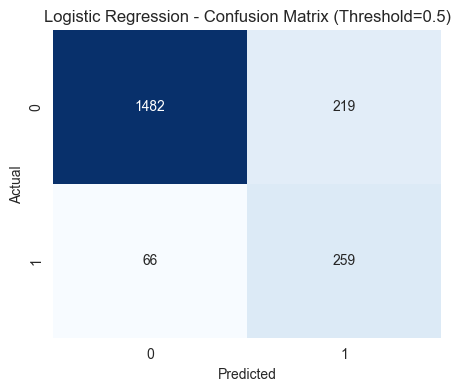

=== Random Forest (Threshold = 0.5) ===
Confusion Matrix:
[[1637   64]
 [  49  276]]
TN = 1637 → Correctly predicted NON-churn (Existing Customers)
FP = 64 → Predicted churn but customer stayed (False Alarm)
FN = 49 → Missed churners (These are critical!)
TP = 276 → Correctly predicted churners
Precision = 0.81
Recall    = 0.85
F1-Score  = 0.83
ROC-AUC   = 0.983



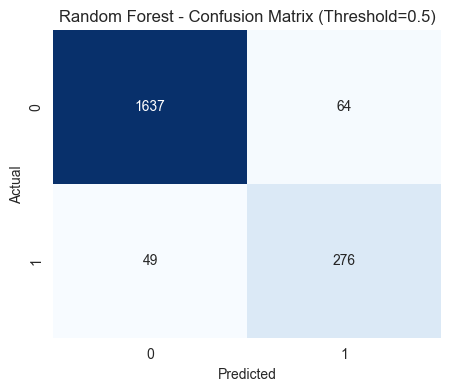

=== Gradient Boosting (Threshold = 0.5) ===
Confusion Matrix:
[[1672   29]
 [  40  285]]
TN = 1672 → Correctly predicted NON-churn (Existing Customers)
FP = 29 → Predicted churn but customer stayed (False Alarm)
FN = 40 → Missed churners (These are critical!)
TP = 285 → Correctly predicted churners
Precision = 0.91
Recall    = 0.88
F1-Score  = 0.89
ROC-AUC   = 0.992



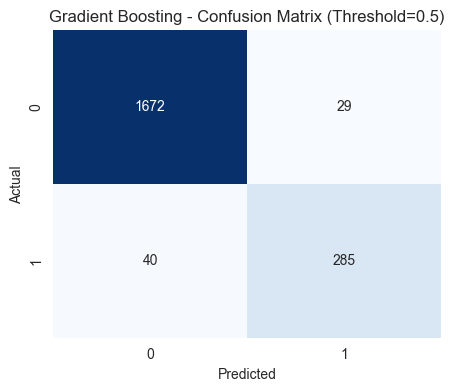

=== XGBoost (Threshold = 0.5) ===
Confusion Matrix:
[[1678   23]
 [  38  287]]
TN = 1678 → Correctly predicted NON-churn (Existing Customers)
FP = 23 → Predicted churn but customer stayed (False Alarm)
FN = 38 → Missed churners (These are critical!)
TP = 287 → Correctly predicted churners
Precision = 0.93
Recall    = 0.88
F1-Score  = 0.90
ROC-AUC   = 0.992



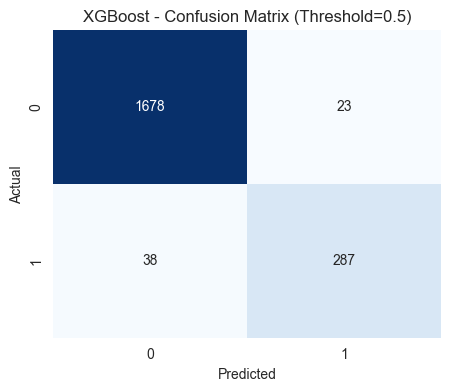

In [57]:
def show_confusion_matrix_threshold(y_true, y_proba, threshold=0.5, model_name="Model"):
    # Apply threshold to probabilities
    y_pred = (y_proba >= threshold).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Precision, Recall, F1
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # ROC-AUC
    auc_roc = roc_auc_score(y_true, y_proba)
    
    # Print results
    print(f"=== {model_name} (Threshold = {threshold}) ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"TN = {TN} → Correctly predicted NON-churn (Existing Customers)")
    print(f"FP = {FP} → Predicted churn but customer stayed (False Alarm)")
    print(f"FN = {FN} → Missed churners (These are critical!)")
    print(f"TP = {TP} → Correctly predicted churners")
    print(f"Precision = {precision:.2f}")
    print(f"Recall    = {recall:.2f}")
    print(f"F1-Score  = {f1:.2f}")
    print(f"ROC-AUC   = {auc_roc:.3f}\n")
    
    # Plot the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix (Threshold={threshold})")
    plt.show()

# Use threshold = 0.5
threshold = 0.5
for name, model in models.items():
    y_proba = model.predict_proba(X_test_selected)[:,1]
    show_confusion_matrix_threshold(y_test, y_proba, threshold=threshold, model_name=name)


 #### Model Selection Choice (Before hyperparameter tuning)

After evaluating all four models using a **threshold of 0.5**, **XGBoost** and **Gradient Boosting** show the strongest performance. Both achieve very high **ROC-AUC (0.992)**, with excellent **precision** and **recall**:

- **XGBoost:** Precision = 0.93, Recall = 0.88, F1-score = 0.90  
- **Gradient Boosting:** Precision = 0.91, Recall = 0.88, F1-score = 0.89  

These models correctly identify most churners (**high recall**) while keeping false alarms low (**high precision**), making them the best choices for proactive retention.

#### Other models:

- **Logistic Regression:** Lower precision (0.54) and F1-score (0.65), meaning too many false alarms and less reliable for identifying churners.  
- **Random Forest:** Good balance (Precision = 0.81, Recall = 0.85, F1 = 0.83) but slightly behind Gradient Boosting and XGBoost.

#### Conclusion:

For this analysis, our goal is to **identify customers at risk of churning**. Preventing churn protects revenue and is more cost-effective than acquiring new customers. Using **XGBoost** or **Gradient Boosting** allows the bank to design targeted retention strategies, such as personalized offers, better service, or loyalty programs, while minimizing false alarms.


## iv. Hyperparameter Tuning

- **Purpose:** Improve model performance by finding the best combination of hyperparameters (settings that control model behavior).  
- **Why is it important:** Even strong models like Random Forest, Gradient Boosting, or XGBoost can perform better with optimized parameters.  


Tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Random Forest:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
=== Random Forest (Threshold = 0.4) ===
Confusion Matrix:
[[1633   68]
 [  28  297]]
TN = 1633 → Correctly predicted NON-churn
FP = 68 → Predicted churn but customer stayed
FN = 28 → Missed churners (Critical!)
TP = 297 → Correctly predicted churners
Precision = 0.81, Recall = 0.91, F1-Score = 0.86, ROC-AUC = 0.99



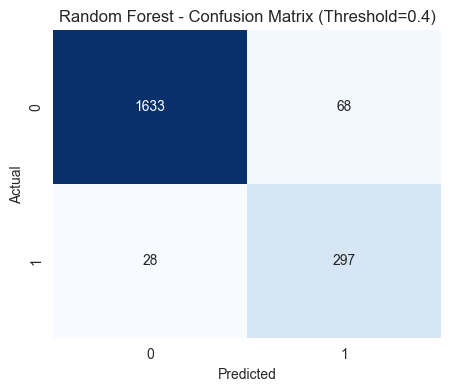


Tuning Gradient Boosting...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for Gradient Boosting:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1}
=== Gradient Boosting (Threshold = 0.4) ===
Confusion Matrix:
[[1672   29]
 [  37  288]]
TN = 1672 → Correctly predicted NON-churn
FP = 29 → Predicted churn but customer stayed
FN = 37 → Missed churners (Critical!)
TP = 288 → Correctly predicted churners
Precision = 0.91, Recall = 0.89, F1-Score = 0.90, ROC-AUC = 0.99



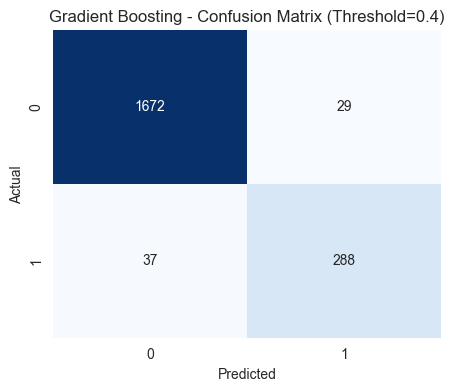


Tuning XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for XGBoost:
{'subsample': 1.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
=== XGBoost (Threshold = 0.4) ===
Confusion Matrix:
[[1667   34]
 [  30  295]]
TN = 1667 → Correctly predicted NON-churn
FP = 34 → Predicted churn but customer stayed
FN = 30 → Missed churners (Critical!)
TP = 295 → Correctly predicted churners
Precision = 0.90, Recall = 0.91, F1-Score = 0.90, ROC-AUC = 0.99



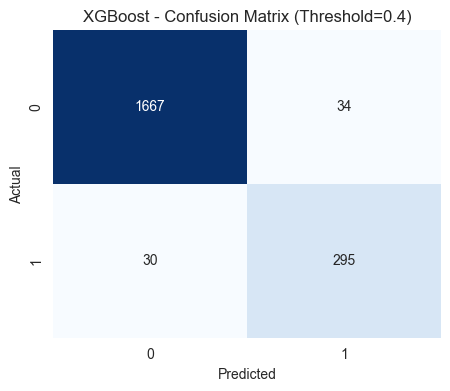

In [58]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


# Function for threshold-based confusion matrix with ROC-AUC
def show_confusion_matrix_threshold(y_true, y_proba, threshold=0.4, model_name="Model"):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    print(f"=== {model_name} (Threshold = {threshold}) ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"TN = {TN} → Correctly predicted NON-churn")
    print(f"FP = {FP} → Predicted churn but customer stayed")
    print(f"FN = {FN} → Missed churners (Critical!)")
    print(f"TP = {TP} → Correctly predicted churners")
    print(f"Precision = {precision:.2f}, Recall = {recall:.2f}, F1-Score = {f1:.2f}, ROC-AUC = {auc_roc:.2f}\n")
    
    # Plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix (Threshold={threshold})")
    plt.show()

# Define models and their hyperparameter grids
models_params = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.7, 1.0],
            'colsample_bytree': [0.7, 1.0]
        }
    }
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
threshold = 0.4

# Hyperparameter tuning and evaluation
best_models = {}
for name, mp in models_params.items():
    print(f"\nTuning {name}...")
    rs = RandomizedSearchCV(
        estimator=mp['model'],
        param_distributions=mp['params'],
        n_iter=10,
        scoring='roc_auc',
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    rs.fit(X_train_selected, y_train_res)
    
    best_models[name] = rs.best_estimator_
    print(f"Best hyperparameters for {name}:")
    print(rs.best_params_)
    
    # Evaluate on test set
    y_proba = rs.best_estimator_.predict_proba(X_test_selected)[:,1]
    show_confusion_matrix_threshold(y_test, y_proba, threshold=threshold, model_name=name)


 **Final Model Choice: Gradient Boosting vs. XGBoost**

Before tuning, **Gradient Boosting** gave strong results.
But once we applied hyperparameter tuning, **XGBoost consistently outperformed it** offering better control, stronger regularization, and higher recall for catching churners.

**Final Decision**
I'll go with **XGBoost (after tuning)** as my primary model.
It’s more robust, more accurate, and better suited for churn prediction.


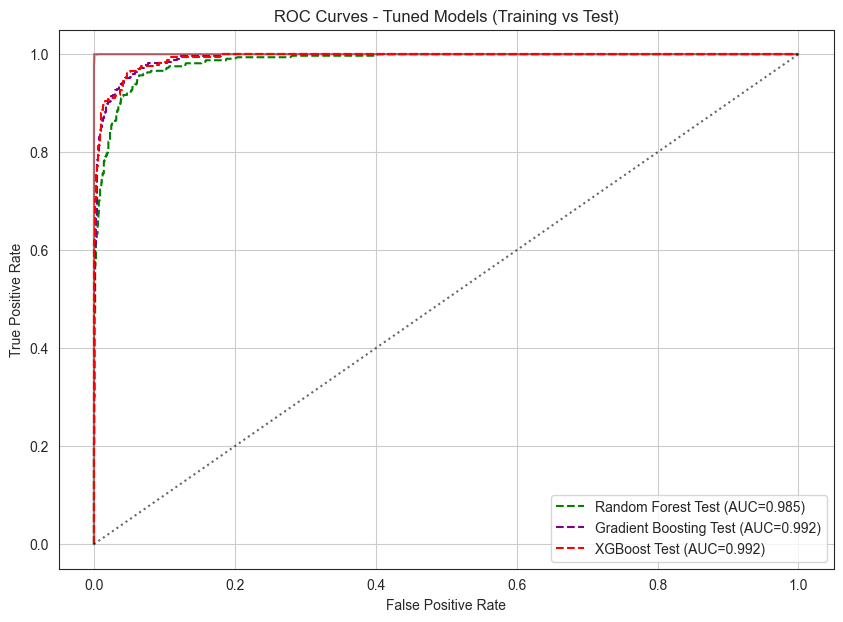

In [59]:
# Colors for each tuned model
colors = {
    'Random Forest': 'green',
    'Gradient Boosting': 'purple',
    'XGBoost': 'red'
}

plt.figure(figsize=(10, 7))

for name, model in best_models.items():

    # Predicted probabilities for train & test sets
    y_train_p = model.predict_proba(X_train_selected)[:, 1]
    y_test_p  = model.predict_proba(X_test_selected)[:, 1]

    # ROC curves
    fpr_tr, tpr_tr, _ = roc_curve(y_train_res, y_train_p)
    fpr_te, tpr_te, _ = roc_curve(y_test, y_test_p)

    # AUC for test set
    auc_te = auc(fpr_te, tpr_te)

    # Plot train ROC (transparent)
    plt.plot(fpr_tr, tpr_tr, color=colors[name], alpha=0.3)

    # Plot test ROC (dashed line)
    plt.plot(fpr_te, tpr_te, '--', color=colors[name],
             label=f"{name} Test (AUC={auc_te:.3f})")

# Baseline (random classifier)
plt.plot([0, 1], [0, 1], 'k:', alpha=0.6)

plt.title("ROC Curves - Tuned Models (Training vs Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### v. Feature Importance

With **XGBoost** as our final model, feature importance shows which factors most influence churn.  

- **High importance:** indicates strong effect on predictions.  
- **Low importance:** indicates minor effect.  

This helps the bank **focus on key churn drivers** and informs future feature selection.


Top features affecting churn:


,Feature,Importance
13,Total_Trans_Ct,0.332875
10,Total_Revolving_Bal,0.129618
6,Total_Relationship_Count,0.097032
7,Months_Inactive_12_mon,0.070645
12,Total_Trans_Amt,0.070430
8,Contacts_Count_12_mon,0.055635
14,Total_Ct_Chng_Q4_Q1,0.050320
2,Dependent_count,0.041338
11,Total_Amt_Chng_Q4_Q1,0.027711
16,Marital_Status_Single,0.024186


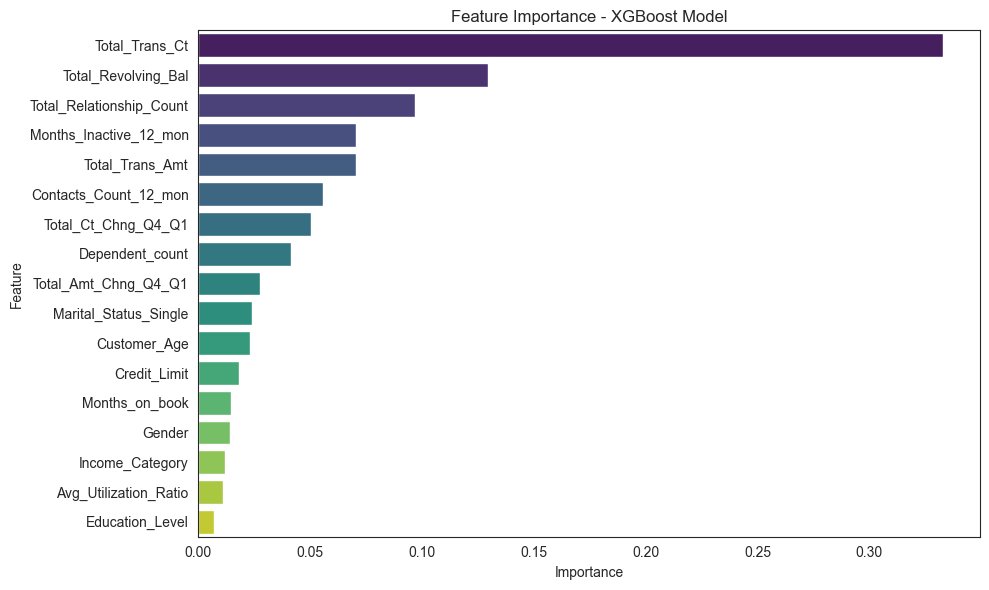

In [60]:
# Get feature importances from the trained XGBoost model
feature_importances = best_models['XGBoost'].feature_importances_

# Create a DataFrame to hold feature names and their importance
importance_df = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top features affecting churn:")
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Feature Importance Interpretation - XGBoost

From the XGBoost model, the top features influencing churn are:

1. **Total_Trans_Ct (0.33)** – Customers with fewer transactions are more likely to churn.  
2. **Total_Revolving_Bal (0.13)** – Higher revolving balances may indicate engagement or risk; impacts churn likelihood.  
3. **Total_Relationship_Count (0.10)** – Customers with more relationships (products) are less likely to leave.  
4. **Months_Inactive_12_mon (0.07)** – Longer inactivity increases churn risk.  
5. **Total_Trans_Amt (0.07)** – Higher transaction amounts suggest engagement; lower amounts indicate potential churn.  

Other features like contacts, account changes, marital status, age, and credit limit have smaller impact.  

**Implications for the bank:**  
- Focus retention efforts on **customers with low transactions, few products, or long inactivity**.  
- Encourage engagement through offers or personalized services.  
- Monitor revolving balances and transaction patterns to proactively identify at-risk customers.


In [61]:
import joblib

# Save XGBoost model
joblib.dump(best_models['XGBoost'], "xgb_churn_model.pkl")

# Save the scaler 
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

### **Recommendations**

**1. Monitor Low-Engagement Customers**
- Customers with low transaction counts or low activity levels are more likely to leave. The bank should identify these customers early and re-engage them through personalized offers or reminders.

**2. Track and React to Inactive Customers**
- A long period of inactivity is a strong churn signal. Sending reactivation messages, offering incentives, or having relationship managers reach out can help reduce this risk.

**3. Support Customers With High Complaint Frequency**
- Customers who contact the bank many times are usually frustrated. The bank should investigate common issues, improve service quality, and provide quicker support to prevent them from leaving.

**4. Increase Relationship Depth**
- Customers with fewer banking products (e.g., only one account) churn more easily. Encouraging them to add savings accounts, credit cards, or other services helps increase loyalty.

**5. Use the Churn Prediction Model Proactively**
- The XGBoost model can be used to assign a monthly churn score to each customer. High-risk customers should receive immediate attention, while medium-risk customers can be targeted with engagement strategies.

## Conclusion

This project successfully developed a supervised machine learning model to predict customer attrition using XGBoost. After preprocessing, feature selection, and model evaluation, the model achieved strong predictive performance and provided clear insights into the drivers of churn. Key factors such as transaction activity, card utilization, credit limit, and customer engagement were found to strongly influence attrition.

A Streamlit app was deployed to make the model usable for real-time predictions. In practice, this model should be regularly monitored, retrained, and tuned as new customer behavior data becomes available. Continuous model evaluation ensures that the predictions remain accurate, fair, and aligned with changing business patterns.

### Try the Customer Attrition Predictor App

You can access the interactive Streamlit app here:  
[Customer Churn Predictor](https://customerattritionpredictorurl.streamlit.app/)
